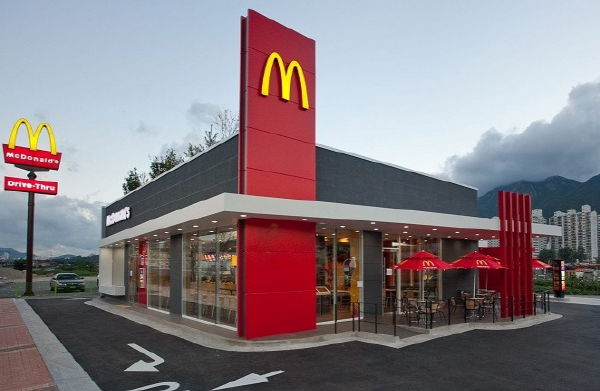

## 대회 설명

### 데이터셋 설명

#### 개요
이 데이터셋은 미국 내 맥도날드 매장에 대한 33,000개 이상의 익명화된 리뷰를 포함하고 있습니다. 이 리뷰들은 Google 리뷰에서 수집되었으며, 미국 전역의 다양한 맥도날드 매장에 대한 고객 경험과 의견을 담고 있습니다. 이 데이터셋은 매장 이름, 카테고리, 주소, 지리적 좌표, 리뷰 평점, 리뷰 텍스트, 타임스탬프 등의 정보를 제공합니다.

#### 변수 설명

- **reviewer_id**: 각 리뷰어에 대한 고유 식별자 (익명화됨)
- **store_name**: 맥도날드 매장의 이름
- **category**: 매장의 카테고리 또는 유형
- **store_address**: 매장의 주소
- **latitude**: 매장 위치의 위도 좌표
- **longitude**: 매장 위치의 경도 좌표
- **rating_count**: 해당 매장의 리뷰 또는 평점 수
- **review_time**: 리뷰 작성 시점의 타임스탬프
- **review**: 리뷰의 텍스트 내용
- **rating**: 리뷰어가 제공한 평점 (1~5점)



### 평가 metric : Weighted F1 Score

#### 개요
다중 클래스 분류 문제에서 예측의 정확성과 오차 크기를 동시에 평가하기 위해 설계된 지표입니다. 이 지표는 각 클래스의 F1 스코어를 기반으로 하며, 예측값과 실제값 간의 차이를 반영하여 가중치를 부여한 후, 최종 점수를 계산하게됩니다.

### 정의
- **F1 Score**: F1 스코어는 각 클래스의 정밀도(Precision)와 재현율(Recall)의 조화 평균입니다. 다중 클래스 문제에서는 각 클래스에 대해 개별적으로 F1 스코어를 계산하고, 이를 평균내어 전체적인 성능을 평가합니다.
- **RMSE (Root Mean Squared Error)**: RMSE는 예측값과 실제값 간의 차이의 제곱을 평균한 후, 제곱근을 취하여 계산됩니다. 이는 예측이 실제값에 얼마나 근접한지를 평가하는 지표입니다.

### 계산 방법
1. 각 클래스에 대해 F1 스코어를 계산합니다.
2. 예측값과 실제값 간의 차이를 계산하여, 차이가 클수록 가중치를 낮추는 방식으로 가중 F1 스코어를 계산합니다.
3. 최종적으로, 가중 F1 스코어를 평균내어 전체적인 성능 지표로 사용합니다.

#### 코드

    def weighted_f1(y_true, y_pred):
        unique_classes = np.unique(y_true)
        f1 = f1_score(y_true, y_pred, labels=unique_classes, average=None)
        
        differences = np.abs(y_true - y_pred)
        
        weights = 1 / (1 + differences)
        
        weighted_f1 = np.sum(weights * f1[y_true - min(unique_classes)]) / np.sum(weights)
        
        return weighted_f1


In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [56]:
# AID 대회 맥도날드 리뷰 평점 예측 베이스라인 코드
# 라이브러리 호출

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import missingno as msno


import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

import re

from collections import Counter
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [29]:
# 데이터셋 불러오기
train_data_path = '/content/train_data.csv'
test_data_path = '/content/test_data.csv'
sample_submission_path = '/content/sample_submission.csv'

train_df = pd.read_csv(train_data_path, encoding="latin-1")
test_df = pd.read_csv(test_data_path, encoding="latin-1")
sample_submission =  pd.read_csv(sample_submission_path, encoding="latin-1")

# 데이터 확인
train_df.head()

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,13426,McDonald's,Fast food restaurant,"1540 2nd St, Santa Monica, CA 90405, United St...",34.012219,-118.494540,"3,380",2 years ago,The manager is rude and speaks to her employee...,1
1,3941,McDonald's,Fast food restaurant,"429 7th Ave, New York, NY 10001, United States",40.750506,-73.990583,"2,052",3 years ago,Good,4
2,30214,McDonald's,Fast food restaurant,"9814 International Dr, Orlando, FL 32819, Unit...",28.423814,-81.461242,"5,468",3 years ago,What a waste of time we were there in line for...,1
3,2354,McDonald's,Fast food restaurant,"72-69 Kissena Blvd, Queens, NY 11367, United S...",40.727401,-73.812460,"2,193",3 years ago,Drive through was smooth and service was good,4
4,20084,McDonald's,Fast food restaurant,"621 Broadway, Newark, NJ 07104, United States",40.771910,-74.161475,"1,564",3 years ago,Excellent,5


## EDA

In [39]:
def null_count():
    return pd.DataFrame({'features': train_df.columns,
                'dtypes': train_df.dtypes.values,
                'NaN count': train_df.isnull().sum().values,
                'NaN percentage': train_df.isnull().sum().values/train_df.shape[0]}).style.background_gradient(cmap='turbo',low=0.1,high=0.01)
null_count()

,features,dtypes,NaN count,NaN percentage
0,reviewer_id,int64,0,0.000000
1,store_name,object,0,0.000000
2,category,object,0,0.000000
3,store_address,object,0,0.000000
4,latitude,float64,0,0.000000
5,longitude,float64,0,0.000000
6,rating_count,object,0,0.000000
7,review_time,object,0,0.000000
8,review,object,0,0.000000
9,rating,int64,0,0.000000


In [40]:
def null_count():
    return pd.DataFrame({'features': test_df.columns,
                'dtypes': test_df.dtypes.values,
                'NaN count': test_df.isnull().sum().values,
                'NaN percentage': test_df.isnull().sum().values/test_df.shape[0]}).style.background_gradient(cmap='turbo',low=0.1,high=0.01)
null_count()

,features,dtypes,NaN count,NaN percentage
0,reviewer_id,int64,0,0.000000
1,store_name,object,0,0.000000
2,category,object,0,0.000000
3,store_address,object,0,0.000000
4,latitude,float64,0,0.000000
5,longitude,float64,0,0.000000
6,rating_count,object,0,0.000000
7,review_time,object,0,0.000000
8,review,object,0,0.000000
9,rating,float64,6548,1.000000


In [41]:
for column in train_df.columns:
    num_distinct_values = len(train_df[column].unique())
    print(f"{column}: {num_distinct_values} 개의 고유한 값")

reviewer_id: 26188 개의 고유한 값
store_name: 2 개의 고유한 값
category: 1 개의 고유한 값
store_address: 39 개의 고유한 값
latitude: 39 개의 고유한 값
longitude: 39 개의 고유한 값
rating_count: 50 개의 고유한 값
review_time: 38 개의 고유한 값
review: 17985 개의 고유한 값
rating: 5 개의 고유한 값


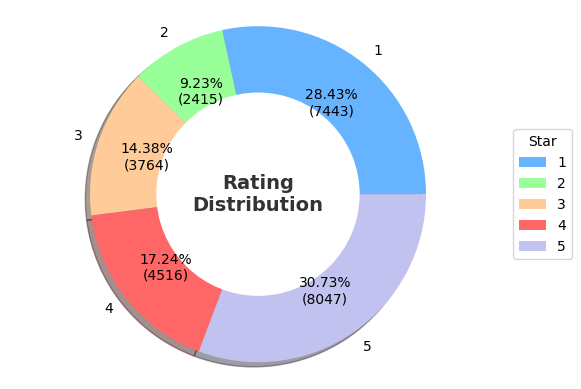

In [59]:
df = train_df.copy()
unique_star = train_df['rating'].unique()

explode = [0] * len(unique_star)

sentiment_counts = df.groupby("rating").size()
colors = ['#66b3ff', '#99ff99', '#ffcc99', '#ff6666', '#c2c2f0']

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    x=sentiment_counts,
    labels=sentiment_counts.index,
    autopct=lambda p: f'{p:.2f}%\n({int(p*sum(sentiment_counts)/100)})',
    wedgeprops=dict(width=0.7),
    textprops=dict(size=10, color="black"),
    pctdistance=0.7,
    colors=colors,
    explode=explode,
    shadow=True
)

center_circle = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=1.25)
fig.gca().add_artist(center_circle)

ax.text(0, 0, 'Rating\nDistribution', ha='center', va='center', fontsize=14, fontweight='bold', color='#333333')

ax.legend(sentiment_counts.index, title="Star", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.axis('equal')

plt.show()

## 전처리

In [30]:
# 데이터 전처리

# rating_count 변수 수치형으로 변경 (콤마 제거)
train_df['rating_count'] = train_df['rating_count'].str.replace(',', '').astype(int)
test_df['rating_count'] = test_df['rating_count'].str.replace(',', '').astype(int)

In [31]:
# review_time 변수 수치형으로 변경 (example: '2 years ago' -> 2)
def convert_review_time(value):
    if 'year' in value:
        if 'a year ago' in value:
            return 1
        return int(value.split()[0])
    elif 'month' in value:
        if 'a month ago' in value:
            return 1
        return int(value.split()[0]) / 12
    elif 'week' in value:
        if 'a week ago' in value:
            return 1
        return int(value.split()[0]) / 52
    elif 'day' in value:
        if 'a day ago' in value:
            return 1
        return int(value.split()[0]) / 365
    elif 'hour' in value:
        if 'an hour ago' in value:
            return 1 / 365 / 24
        return int(value.split()[0]) / 365 / 24
    return 0

train_df['review_time'] = train_df['review_time'].apply(convert_review_time)
test_df['review_time'] = test_df['review_time'].apply(convert_review_time)

In [32]:
# store_address 변수 활용

train_df[['store_address']].sample(5)

,store_address
2390,"1916 M St NW, Washington, DC 20036, United States"
2145,"1698 US-209, Brodheadsville, PA 18322, United ..."
1553,"25200 I-10 Lot 2, San Antonio, TX 78257, Unite..."
17429,"1698 US-209, Brodheadsville, PA 18322, United ..."
25625,"1415 E State Rd, Fern Park, FL 32730, United S..."


In [33]:
train_df[['City', 'State']] = train_df['store_address'].apply(lambda x: pd.Series(x.split(', ')[-3:-1]))
test_df[['City', 'State']] = test_df['store_address'].apply(lambda x: pd.Series(x.split(', ')[-3:-1]))

train_df[['City','State']].sample(5)

,City,State
17493,Queens,NY 11367
1584,New York,NY 10003
15741,Annandale,VA 22003
25457,Washington,DC 20036
25197,New York,NY 10001


In [37]:
# 결측치 처리 (있는 경우)
train_df.fillna('', inplace=True)
test_df.fillna('', inplace=True)

<ipython-input-37-dfb54456f848>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  test_df.fillna('', inplace=True)


## Feature Engineering

In [36]:
train_df.head(3)

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating,City,State
0,13426,McDonald's,Fast food restaurant,"1540 2nd St, Santa Monica, CA 90405, United St...",34.012219,-118.494540,3380,2.0,The manager is rude and speaks to her employee...,1,Santa Monica,CA 90405
1,3941,McDonald's,Fast food restaurant,"429 7th Ave, New York, NY 10001, United States",40.750506,-73.990583,2052,3.0,Good,4,New York,NY 10001
2,30214,McDonald's,Fast food restaurant,"9814 International Dr, Orlando, FL 32819, Unit...",28.423814,-81.461242,5468,3.0,What a waste of time we were there in line for...,1,Orlando,FL 32819


In [38]:
# 피처 엔지니어링
# 다음 특징들을 사용: 'City', 'State', 'latitude', 'longitude', 'review_time', 'review'
features = ['City', 'State','latitude', 'longitude', 'review_time', 'review']
X_train = train_df[features]
X_test = test_df[features]
y_train = train_df['rating']
y_test = test_df['rating']

In [39]:
X_train

,City,State,latitude,longitude,review_time,review
0,Santa Monica,CA 90405,34.012219,-118.494540,2.000000,The manager is rude and speaks to her employee...
1,New York,NY 10001,40.750506,-73.990583,3.000000,Good
2,Orlando,FL 32819,28.423814,-81.461242,3.000000,What a waste of time we were there in line for...
3,Queens,NY 11367,40.727401,-73.812460,3.000000,Drive through was smooth and service was good
4,Newark,NJ 07104,40.771910,-74.161475,3.000000,Excellent
...,...,...,...,...,...,...
26183,Sunnyvale,CA 94086,37.385495,-121.995421,4.000000,McDonald's just have the best fries no matter ...
26184,New York,NY 10001,40.752529,-73.992876,0.583333,The staff rushes you out the second you're don...
26185,Austin,TX 78724,30.329135,-97.660629,4.000000,Its Mcdonlds what can i say i grew up with hap...
26186,Newark,NJ 07104,40.771910,-74.161475,3.000000,Excellent


In [40]:
y_train

,rating
0,1
1,4
2,1
3,4
4,5
...,...
26183,5
26184,3
26185,3
26186,5


In [41]:
def clean_review(review):
    review = review.lower()
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    review = re.sub(r'\s+', ' ', review).strip()

    stop_words = set(stopwords.words('english'))
    review_tokens = nltk.word_tokenize(review)
    review = ' '.join([word for word in review_tokens if word not in stop_words])


    return review

X_train['clean_reviews'] = X_train['review'].apply(clean_review)
X_test['clean_reviews'] = X_test['review'].apply(clean_review)

X_train = X_train.drop(columns=['review'])
X_test = X_test.drop(columns=['review'])

<ipython-input-41-d26cba8e093d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['clean_reviews'] = X_train['review'].apply(clean_review)
<ipython-input-41-d26cba8e093d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['clean_reviews'] = X_test['review'].apply(clean_review)


In [42]:
specified_columns = ['City', 'State', 'review_time']

for col in specified_columns:
    total_unique_values = X_train[col].nunique()
    print(f'Total unique values for {col}: {total_unique_values}')

    top_values = X_train[col].value_counts()

    for i, (value, count) in enumerate(top_values.items()):
        print(f'{value}: {count}')

    print('\n' + '=' * 30 + '\n')

Total unique values for City: 26
New York: 2724
Orlando: 2491
Austin: 1374
Kissimmee: 1372
North Hollywood: 1370
Fern Park: 1367
Dallas: 1318
Miami: 1252
Newark: 1019
San Diego: 980
Roanoke: 943
Queens: 929
Brodheadsville: 839
Los Angeles: 830
Las Vegas: 812
Voorhees Township: 763
Salt Lake City: 698
Fort Worth: 682
Santa Monica: 670
Sunnyvale: 649
Oak Park: 604
Washington: 558
San Antonio: 513
Champlain: 493
Annandale: 482
Miami Beach: 456


Total unique values for State: 36
FL 32819: 1935
NY 10001: 1617
FL 34746: 1372
CA 91602: 1370
FL 32730: 1367
TX 75203: 1318
FL 33137: 1252
NJ 07104: 1019
TX 76262: 943
NY 11367: 929
NY 10003: 887
PA 18322: 839
NV 89119: 812
NJ 08043: 763
TX 78724: 732
UT 84106: 698
TX 76177: 682
CA 90405: 670
CA 94086: 649
TX 78750: 642
IL 60302: 604
DC 20036: 556
FL 32837: 556
CA 92109: 542
TX 78257: 513
NY 12919: 493
VA 22003: 482
FL 33139: 456
CA 90021: 443
CA 92111: 438
CA 90044: 385
NY 10013: 214
NY 10002: 3
NY 10038: 3
DC 20004: 2
CA 90025: 2


Total unique 

## Train

#### 감성분석

In [43]:
df_review_train =  pd.DataFrame(X_train["clean_reviews"])
df_review_test = pd.DataFrame(X_test["clean_reviews"])

df_review_train.head()

,clean_reviews
0,manager rude speaks employees spanish insult c...
1,good
2,waste time line minutes woman window asked rec...
3,drive smooth service good
4,excellent


In [44]:
analyzer = SentimentIntensityAnalyzer()

df_review_train['sentiment_score'] = df_review_train['clean_reviews'].apply(lambda text: analyzer.polarity_scores(text)['compound'])
df_review_test['sentiment_score'] = df_review_test['clean_reviews'].apply(lambda text: analyzer.polarity_scores(text)['compound'])

df_review_train['sentiment'] = df_review_train['sentiment_score'].apply(lambda score: 'positive' if score >= 0.05 else ('negative' if score <= -0.05 else 'neutral'))
df_review_test['sentiment'] = df_review_test['sentiment_score'].apply(lambda score: 'positive' if score >= 0.05 else ('negative' if score <= -0.05 else 'neutral'))

X_train[['sentiment', 'sentiment_score']] = df_review_train[['sentiment', 'sentiment_score']]
X_test[['sentiment', 'sentiment_score']] = df_review_test[['sentiment', 'sentiment_score']]

df_review_train[['clean_reviews', 'sentiment_score', 'sentiment']].head()

,clean_reviews,sentiment_score,sentiment
0,manager rude speaks employees spanish insult c...,-0.5994,negative
1,good,0.4404,positive
2,waste time line minutes woman window asked rec...,-0.6124,negative
3,drive smooth service good,0.4404,positive
4,excellent,0.5719,positive


In [45]:
X_train

,City,State,latitude,longitude,review_time,clean_reviews,sentiment,sentiment_score
0,Santa Monica,CA 90405,34.012219,-118.494540,2.000000,manager rude speaks employees spanish insult c...,negative,-0.5994
1,New York,NY 10001,40.750506,-73.990583,3.000000,good,positive,0.4404
2,Orlando,FL 32819,28.423814,-81.461242,3.000000,waste time line minutes woman window asked rec...,negative,-0.6124
3,Queens,NY 11367,40.727401,-73.812460,3.000000,drive smooth service good,positive,0.4404
4,Newark,NJ 07104,40.771910,-74.161475,3.000000,excellent,positive,0.5719
...,...,...,...,...,...,...,...,...
26183,Sunnyvale,CA 94086,37.385495,-121.995421,4.000000,mcdonalds best fries matter time day go matter...,positive,0.8625
26184,New York,NY 10001,40.752529,-73.992876,0.583333,staff rushes second youre done eating,neutral,0.0000
26185,Austin,TX 78724,30.329135,-97.660629,4.000000,mcdonlds say grew happy meals,positive,0.5719
26186,Newark,NJ 07104,40.771910,-74.161475,3.000000,excellent,positive,0.5719


In [46]:
Positive_sent = df_review_train[df_review_train['sentiment'] == 'positive']
Negative_sent = df_review_train[df_review_train['sentiment'] == 'negative']
Neutral_sent = df_review_train[df_review_train['sentiment'] == 'neutral']

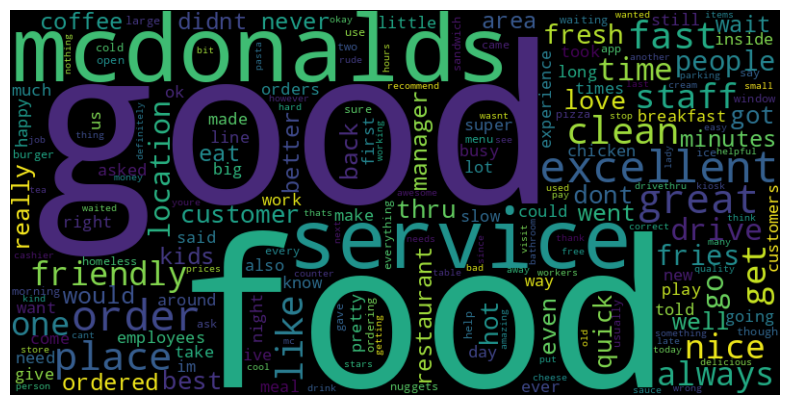

In [47]:
# 긍정 단어들

df_review_train['temp_list'] = df_review_train['clean_reviews'].apply(lambda x: str(x).split())

top = Counter([item for sublist in df_review_train[df_review_train['sentiment'] == 'positive']['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(), columns=['Common_words', 'count'])

wordcloud_data = temp_neutral.set_index('Common_words')['count'].to_dict()

wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(wordcloud_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


#### 모델링

In [48]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26188 entries, 0 to 26187
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   City             26188 non-null  object 
 1   State            26188 non-null  object 
 2   latitude         26188 non-null  float64
 3   longitude        26188 non-null  float64
 4   review_time      26188 non-null  float64
 5   clean_reviews    26188 non-null  object 
 6   sentiment        26188 non-null  object 
 7   sentiment_score  26188 non-null  float64
dtypes: float64(4), object(4)
memory usage: 1.6+ MB


In [49]:
# 데이터 준비
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [50]:
# 원-핫 인코딩을 위한 ColumnTransformer 생성
column_transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), ['City', 'State', 'sentiment'])
    ],
    remainder='passthrough'  # 나머지 열들은 그대로 유지
)

In [51]:
# 데이터 변환
X_train_encoded = column_transformer.fit_transform(X_train.drop(columns=['clean_reviews']))
X_val_encoded = column_transformer.transform(X_val.drop(columns=['clean_reviews']))
X_test_encoded = column_transformer.transform(X_test.drop(columns=['clean_reviews']))

In [54]:
# 모델 초기화 및 훈련
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_encoded, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

In [55]:
# 예측
y_train_pred = model.predict(X_train_encoded)
y_val_pred = model.predict(X_val_encoded)
y_test_pred = model.predict(X_test_encoded)

In [57]:
# 평가 metric에 사용되는 weighted_f1 함수
def weighted_f1(y_true, y_pred):
    unique_classes = np.unique(y_true)
    f1 = f1_score(y_true, y_pred, labels=unique_classes, average=None)

    differences = np.abs(y_true - y_pred)

    weights = 1 / (1 + differences)

    weighted_f1 = np.sum(weights * f1[y_true - min(unique_classes)]) / np.sum(weights)

    return weighted_f1


In [58]:
# 평가 지표 계산
train_f1_weighted = f1_score(y_train, y_train_pred, average='weighted')
val_f1_weighted = f1_score(y_val, y_val_pred, average='weighted')

# 결과 출력
print(f"Train Weighted F1 Score: {train_f1_weighted}")
print(f"Validation Weighted F1 Score: {val_f1_weighted}")

Train Weighted F1 Score: 0.45108977135826844
Validation Weighted F1 Score: 0.44599481540238683


In [59]:
# 최종 예측 결과 출력 (또는 저장)
print("Test Predictions:", y_test_pred[:10])  # 예시로 처음 10개의 예측을 출력

Test Predictions: [1 5 5 5 1 1 3 5 5 5]


## Submission 제출

In [60]:
sample_submission

,reviewer_id,predicted_rating
0,30169,NaN
1,31991,NaN
2,25267,NaN
3,20406,NaN
4,26464,NaN
...,...,...
6543,26294,NaN
6544,25381,NaN
6545,8792,NaN
6546,20670,NaN


In [61]:
sample_submission['predicted_rating'] = y_test_pred
sample_submission.head()

,reviewer_id,predicted_rating
0,30169,1
1,31991,5
2,25267,5
3,20406,5
4,26464,1


In [62]:
sample_submission.to_csv('team00_attempt_01.csv', index=False)